In [14]:
"""
CoastScout_Explorer_EWTEC

Python tools for exploring CoastScout/CDIP data
The notebook creates the relevant outputs for the EWTEC paper


Contact: Bryan Murray, bryan@calwave.energy

Change Log:
    + 12/29/20 [BRM]: First commit. New notebook created from elements of "CoastScout_Explorer" and "CoastScout_Explorer_Frequency"
    + 

"""

'\nCoastScout_Explorer_EWTEC\n\nPython tools for exploring CoastScout/CDIP data\nThe notebook creates the relevant outputs for the EWTEC paper\n\n\nContact: Bryan Murray, bryan@calwave.energy\n\nChange Log:\n    + 12/29/20 [BRM]: First commit. New notebook created from elements of "CoastScout_Explorer" and "CoastScout_Explorer_Frequency"\n    + \n\n'

In [15]:
import pandas as pd
import numpy as np
import datetime
import netCDF4
import time
import calendar
import matplotlib.pyplot as plt
#%matplotlib notebook

In [16]:
def iso2posix(iso_timestamp):
    '''Convert CoastScout's ISO-formated date strings to datetime, then posix timestamp'''
    import datetime
    dt = datetime.datetime.fromisoformat(iso_timestamp)
    return dt.timestamp()

In [17]:
# Import CoastScout Data
# CS "report_time" field is in UTC

def report_timestamp2datetime(report_timestamp):
    import datetime
    fmt = '%Y-%m-%dT%H:%M:%S+00:00'
    return datetime.datetime.strptime(report_timestamp,fmt)

p2csdata = r'Scripps02_FebAug2020.csv'
cs = pd.read_csv(p2csdata,
                  parse_dates=[2],
                  date_parser=report_timestamp2datetime)

# create "tepoch" column to hold posix time stamps
cs['tepoch'] = cs.report_timestamp.apply(lambda dt: int(dt.timestamp()))

In [18]:
# Open local copy of CDIP201 netCDF "real-time" file
# it happens to cover February - August 2020
p2CDIP201_rt = r'201p1_rt_FebAug2020.nc'
ds = netCDF4.Dataset(p2CDIP201_rt)
ds.set_always_mask(False)

# Create pandas DataFrame for CDIP201
dsTime = ds.variables['waveTime'][:]
timeall = [datetime.datetime.fromtimestamp(t) for t in dsTime] # Convert ncTime variable to datetime stamps
Hs = ds.variables['waveHs'][:]
Tp = ds.variables['waveTp'][:]
Dp = ds.variables['waveDp'][:] 

data = {'t':dsTime,'dt':timeall,'Hs':Hs,'Tp':Tp,'Dp':Dp}
cdip201 = pd.DataFrame(data)
cdip201 = cdip201.set_index('t')

In [20]:
# To align Scripps02 and CDIP201, we'll create a column holding posix time stamps
# we can then use the timestamps for a join

# First the CoastScout buoy
cs['thh'] = cs.tepoch
cs.thh= cs.thh.apply(lambda ti: ti - (ti%1800)) 
cs = cs.set_index('thh')

# round buoy 201 'nearshore' down to half-hour
cdip201['thh'] = cdip201.index
cdip201.thh= cdip201.thh.apply(lambda ti: ti - (ti%1800))
cdip201 = cdip201.set_index('thh')

df = pd.merge(cdip201,cs,left_index=False,right_index=True,how='inner',on=['thh','thh']) #<-- returns empty
df.dropna(inplace=True)
df['dt'] = df.tepoch.apply(lambda thh: datetime.datetime.fromtimestamp(thh))
#df.to_csv(r'path\cdip_cs.csv')

In [ ]:
df.Hs[(df.Hs<1.0) & (df.wave_significant_height_m<1.0)]

[0.01116098 0.94250781]


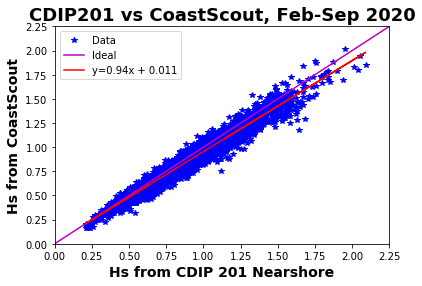

In [21]:
# Simple regression of Hs vs Hs to get an R value for EWTEC abstract
fig = plt.figure()

import numpy.polynomial.polynomial as poly
# poly.polyfit returns [A,B,C] for A + Bx + Cx^2 + Dx^3...

# Hs
#coefs_Hs = poly.polyfit(df.Hs[(df.Hs<1.0) & (df.wave_significant_height_m<1.0)],df.wave_significant_height_m[(df.Hs<1.0) & (df.wave_significant_height_m<1.0)], 1)
coefs_Hs = poly.polyfit(df.Hs,df.wave_significant_height_m, 1)
print(coefs_Hs)
ffit_Hs = poly.polyval(df.Hs, coefs_Hs)

ax1 = fig.add_subplot(111)
ax1.plot(df.Hs,df.wave_significant_height_m,'b*')
ax1.plot([0,2.25],[0,2.25],'m-')
ax1.plot(df.Hs, ffit_Hs,'r-')
ax1.set_xlim([0,2.25])
ax1.set_ylim([0,2.25])
ax1.set_xlabel('Hs from CDIP 201 Nearshore',fontsize=14,weight='bold')
ax1.set_ylabel('Hs from CoastScout',fontsize=14,weight='bold')
ax1.set_title('CDIP201 vs CoastScout, Feb-Sep 2020',fontsize=18,weight='bold')
ax1.legend(['Data','Ideal','y='+str(round(coefs_Hs[1],2)) + 'x + ' + str(round(coefs_Hs[0],3))])
#ax1.text(.85,.25,'Negative slope implies\n that CDIP over-estimates Hs,\n or CoastScout under-estimates',fontsize=14,weight='bold',color='r')

Text(0.5, 1.0, 'Dp')

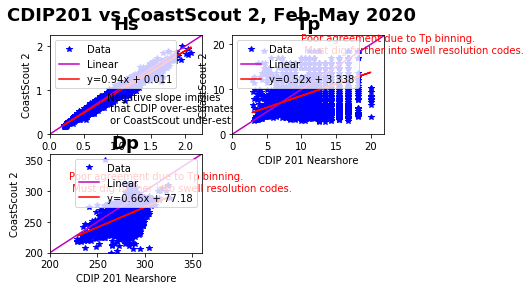

In [24]:
#%% Comparison Compendium
fig = plt.figure()
plt.suptitle('CDIP201 vs CoastScout 2, Feb-May 2020',fontsize=18,weight='bold')

import numpy.polynomial.polynomial as poly
# poly.polyfit returns [A,B,C] for A + Bx + Cx^2 + Dx^3...

# Hs
coefs_Hs = poly.polyfit(df.Hs,df.wave_significant_height_m, 1)
ffit_Hs = poly.polyval(df.Hs, coefs_Hs)

ax1 = fig.add_subplot(221)
ax1.plot(df.Hs,df.wave_significant_height_m,'b*')
ax1.plot([0,2.25],[0,2.25],'m-')
ax1.plot(df.Hs, ffit_Hs,'r-')
ax1.set_xlim([0,2.25])
ax1.set_ylim([0,2.25])
ax1.set_xlabel('CDIP 201 Nearshore')
ax1.set_ylabel('CoastScout 2')
ax1.legend(['Data','Linear','y='+str(round(coefs_Hs[1],2)) + 'x + ' + str(round(coefs_Hs[0],3))])
ax1.text(.85,.25,'Negative slope implies\n that CDIP over-estimates Hs,\n or CoastScout under-estimates')
ax1.set_title('Hs',fontsize=18,weight='bold')

# Tp
coefs_Tp = poly.polyfit(df.Tp,df.wave_peak_period_seconds, 1)
ffit_Tp = poly.polyval(df.Tp, coefs_Tp)

ax2 = fig.add_subplot(222)
ax2.plot(df.Tp,df.wave_peak_period_seconds,'b*')
ax2.plot([0,22],[0,22],'m-')
ax2.plot(df.Tp, ffit_Tp,'r-')
ax2.set_xlim([0,22])
ax2.set_ylim([0,22])
ax2.set_xlabel('CDIP 201 Nearshore')
ax2.set_ylabel('CoastScout 2')
ax2.legend(['Data','Linear','y='+str(round(coefs_Tp[1],2)) + 'x + ' + str(round(coefs_Tp[0],3))])
ax2.text(10,18,'Poor agreement due to Tp binning. \n Must dig further into swell resolution codes.',color='r')
ax2.set_title('Tp',fontsize=18,weight='bold')

# Dp
coefs_Dp = poly.polyfit(df.Dp,df.wave_mean_direction_degrees, 1)
ffit_Dp = poly.polyval(df.Dp, coefs_Dp)

ax3 = fig.add_subplot(223)
ax3.plot(df.Dp,df.wave_mean_direction_degrees,'b*')
ax3.plot([200,360],[200,360],'m-')
ax3.plot(df.Dp, ffit_Dp,'r-')
ax3.set_xlim([200,360])
ax3.set_ylim([200,360])
ax3.set_xlabel('CDIP 201 Nearshore')
ax3.set_ylabel('CoastScout 2')
ax3.legend(['Data','Linear','y='+str(round(coefs_Dp[1],2)) + 'x + ' + str(round(coefs_Dp[0],3))])
ax3.text(220,300,'Poor agreement due to Tp binning. \n Must dig further into swell resolution codes.',color='r')
ax3.set_title('Dp',fontsize=18,weight='bold')